In [1]:
# pip install --force-reinstall --upgrade git+https://github.com/SerjWeesp/AmarinML.git

In [2]:
from amarinml import *

In [3]:
import numpy as np
import pandas as pd
import copy
import os
import joblib
import ctypes
from probatus.feature_elimination import ShapRFECV
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from catboost import CatBoostRegressor, Pool
from feature_engine.outliers import OutlierTrimmer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, RecursiveFeatureElimination
import shap
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score

os.environ.pop("OPENBLAS_NUM_THREADS", None)  # None = ignore if not present
SEED = 23
pd.set_option('display.max_columns', None)

In [4]:
# tell Windows to stay awake
ctypes.windll.kernel32.SetThreadExecutionState(0x80000000 | 0x00000001)

-2147483648

In [ ]:
class SinglePointTimeSeriesSplitByTicker:
    """
    Time series cross-validator that yields single point test sets by ticker.
    Compatible with scikit-learn's cross_val_score and BayesSearchCV.

    Parameters
    ----------
    n_splits : int, default=3
        Number of splits. Must be at least 1.
    """

    def __init__(self, n_splits=3):
        if n_splits < 1:
            raise ValueError(f"n_splits must be >= 1, got {n_splits}")
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test sets."""
        if not isinstance(X, pd.DataFrame):
            raise ValueError(
                "X must be a pandas DataFrame with 'Ticker' column")

        if 'Ticker' not in X.columns:
            raise ValueError("DataFrame must have a 'Ticker' column")

        # Group by ticker once
        grouped = dict(tuple(X.groupby('Ticker')))
        indices = np.arange(len(X))

        for i in range(self.n_splits):
            train_indices = []
            test_indices = []

            for ticker, ticker_df in grouped.items():
                ticker_indices = indices[X['Ticker'] == ticker]
                split_idx = len(ticker_indices) - (i + 1)

                if split_idx > 0:  # Ensure we have enough data
                    train_indices.extend(ticker_indices[:split_idx])
                    test_indices.extend(
                        ticker_indices[split_idx:split_idx + 1])

            if test_indices:  # Only yield if we have test data
                gc.collect()
                yield np.array(train_indices), np.array(test_indices)

    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations."""
        return self.n_splits

In [6]:
# Define RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [8]:
df = pd.read_csv('D:\GitHub\sp500\sp500_diff.csv', low_memory=False)
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)
df.sort_values(by=['Ticker', 'Date'], inplace=True)
df.drop(['Quarter_pct_diff_1', 'Quarter_pct_diff_4',
        'Fiscal year_pct_diff_1', 'Fiscal year_pct_diff_4', 'Fiscal year'], axis=1, inplace=True)
df['Quarter'] = df['Quarter'].astype('int64').astype('category')
print(df.shape)

(7782, 1128)


In [9]:
target = 'Future_Price_pct_diff_1'
df[target] = df.groupby('Ticker')['ClosePrice_pct_diff_1'].shift(-1)

predict_df = pd.DataFrame()
for ticker in df['Ticker'].unique():
    ticker_df = df[df['Ticker'] == ticker]
    max_date = ticker_df['Date'].max()
    last_row = ticker_df.loc[ticker_df['Date'] == max_date, :].copy()
    predict_df = pd.concat([predict_df, last_row], ignore_index=True)

df.dropna(inplace=True)
features = df.drop(columns=[target,  'Date'], axis=1).columns.tolist()
cat_features = df.drop(columns=[target, 'Date'], axis=1).select_dtypes(
    include=['object', 'category']).columns.tolist()
num_features = df.drop(columns=[target], axis=1).select_dtypes(
    include=['int64', 'float64']).columns.tolist()
print(
    f'Length of numerical features: {len(num_features)}, categorical: {len(cat_features)} , all features: {len(features)}')

Length of numerical features: 1123, categorical: 4 , all features: 1127


In [ ]:
split_date = '2025-01-01'
train_df = df[df['Date'] < split_date].copy()
test_df = df[df['Date'] >= split_date].copy()
X_train = train_df[features]

y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

In [11]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    random_seed=SEED,
    verbose=False,
    thread_count=-1,
    devices='0',
    task_type="GPU",
    gpu_ram_part=0.8,
    data_partition='DocParallel',
    max_ctr_complexity=2,
    cat_features=cat_features,
)

tscv = SinglePointTimeSeriesSplitByTicker(n_splits=4)

scores = cross_val_score(model, X_train, y_train, cv=tscv,
                         scoring='neg_root_mean_squared_error')
print(scores)

[-0.1425833  -0.16636077 -0.17459237 -0.12905511]


In [12]:
model.fit(X_train, y_train, cat_features=cat_features, verbose=False)

# Retrieve feature importances
importances = model.get_feature_importance()

# Retrieve the corresponding feature names (if available)
feature_names = model.feature_names_

# Create a DataFrame with the feature names and their importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the DataFrame in descending order by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Print the top 30 important features
print(importance_df.head(30))

                                           feature  importance
288                                        Quarter    3.767805
179                                      MACD_Hist    2.385305
757                        MedianVolume_pct_diff_1    1.470327
955                              RSI_14_pct_diff_1    1.269084
956                              RSI_14_pct_diff_4    1.171388
290                                         RSI_14    1.152657
586   Foreign Exchange Rate Adjustments_pct_diff_4    1.114888
642        Interest & Investment Income_pct_diff_4    1.033877
763                           MinVolume_pct_diff_1    0.966795
736                           MACD_Hist_pct_diff_4    0.868431
104              Foreign Exchange Rate Adjustments    0.864985
85                                   EV/EBIT Ratio    0.851971
472        Comprehensive Income & Other_pct_diff_4    0.839787
753                          MeanVolume_pct_diff_1    0.775711
734                                MACD_pct_diff_4    0

c:\Users\Dell\venv\Lib\site-packages\probatus\utils\arrayfuncs.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[object_columns] = X[object_columns].astype("category")
C:\Users\Dell\AppData\Local\Temp\ipykernel_33288\43222407.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dict(tuple(X.groupby('Ticker')))
C:\Users\Dell\AppData\Local\Temp\ipykernel_33288\43222407.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

Selected: ['Ticker', 'Book Value Per Share', 'ClosePrice', 'Debt / EBITDA Ratio', 'EV/EBIT Ratio', 'Free Cash Flow Per Share', 'Income Tax Expense', 'Interest & Investment Income', 'MACD_Hist', 'Market Capitalization', 'Operating Cash Flow', 'Quarter', 'RSI_14', 'GICS Sector', 'GICS Sub-Industry', 'Asset Turnover_pct_diff_4', 'ClosePrice_pct_diff_1', 'Comprehensive Income & Other_pct_diff_1', 'Comprehensive Income & Other_pct_diff_4', 'D&A For EBITDA_pct_diff_1', 'Debt / EBITDA Ratio_pct_diff_1', 'EBITDA_pct_diff_1', 'EV/EBIT Ratio_pct_diff_1', 'EV/FCF Ratio_pct_diff_1', 'Foreign Exchange Rate Adjustments_pct_diff_1', 'Foreign Exchange Rate Adjustments_pct_diff_4', 'Forward PE_pct_diff_1', 'Free Cash Flow_pct_diff_4', 'Goodwill_pct_diff_1', 'Interest & Investment Income_pct_diff_4', 'MACD_pct_diff_4', 'MACD_Hist_pct_diff_1', 'MACD_Hist_pct_diff_4', 'MACD_Signal_pct_diff_4', 'MaxVolume_pct_diff_4', 'MeanVolume_pct_diff_1', 'MedianPrice_pct_diff_4', 'MedianVolume_pct_diff_1', 'MinPrice_p

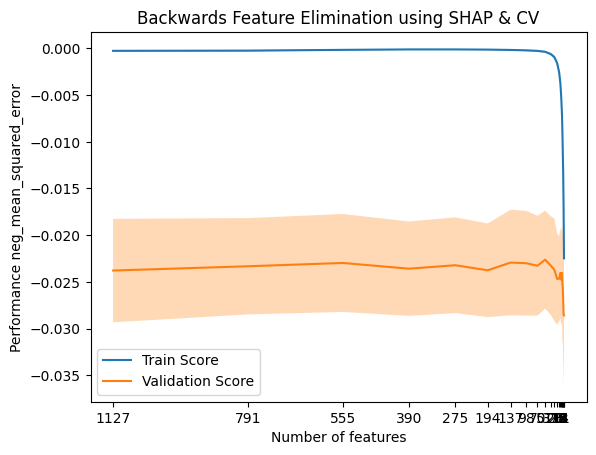

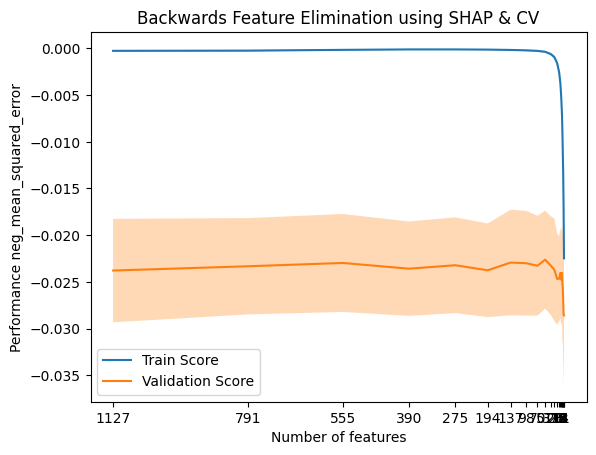

In [ ]:
shap_selector = ShapRFECV(
    model=model,
    cv=tscv,
    step=0.3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=0,
    random_state=SEED)

shap_selector.fit(X_train, y_train, columns_to_keep=cat_features)
selected = shap_selector.get_reduced_features_set('best')
print("Selected:", selected)
shap_selector.plot()

In [ ]:
selected = ['Ticker', 'Book Value Per Share', 'ClosePrice', 'Debt / EBITDA Ratio', 'EV/EBIT Ratio', 'Free Cash Flow Per Share', 'Income Tax Expense', 'Interest & Investment Income',
            'MACD_Hist', 'Market Capitalization', 'Operating Cash Flow', 'Quarter', 'RSI_14', 'GICS Sector', 'GICS Sub-Industry', 'Asset Turnover_pct_diff_4', 'ClosePrice_pct_diff_1',
            'Comprehensive Income & Other_pct_diff_1', 'Comprehensive Income & Other_pct_diff_4', 'D&A For EBITDA_pct_diff_1', 'Debt / EBITDA Ratio_pct_diff_1', 'EBITDA_pct_diff_1',
            'EV/EBIT Ratio_pct_diff_1', 'EV/FCF Ratio_pct_diff_1', 'Foreign Exchange Rate Adjustments_pct_diff_1', 'Foreign Exchange Rate Adjustments_pct_diff_4', 'Forward PE_pct_diff_1',
            'Free Cash Flow_pct_diff_4', 'Goodwill_pct_diff_1', 'Interest & Investment Income_pct_diff_4', 'MACD_pct_diff_4', 'MACD_Hist_pct_diff_1', 'MACD_Hist_pct_diff_4',
            'MACD_Signal_pct_diff_4', 'MaxVolume_pct_diff_4', 'MeanVolume_pct_diff_1', 'MedianPrice_pct_diff_4', 'MedianVolume_pct_diff_1', 'MinPrice_pct_diff_1', 'MinVolume_pct_diff_1',
            'Net Cash (Debt)_pct_diff_4', 'Net Cash Flow_pct_diff_4', 'Operating Income_pct_diff_4', 'Other Long-Term Assets_pct_diff_4', 'P/OCF Ratio_pct_diff_4', 'PB Ratio_pct_diff_4',
            'PEG Ratio_pct_diff_4', 'Pretax Income_pct_diff_1', 'RSI_14_pct_diff_1', 'RSI_14_pct_diff_4', 'StdPrice_pct_diff_4']

In [15]:
n_iter = 30

# Define search space
param_space = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'depth': Integer(3, 12),
    'l2_leaf_reg': Real(1e-9, 10, prior='log-uniform'),
    'iterations': Integer(100, 1000),
    'random_strength': Real(1e-9, 10, prior='log-uniform'),
    'bagging_temperature': Real(0.0, 1.0),
    'min_data_in_leaf': Integer(1, 100),
    'leaf_estimation_iterations': Integer(1, 20)
}

# Initialize the progress bar with the number of iterations
callback = TqdmCallback(total=n_iter)

opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=n_iter,
    cv=None,
    scoring=make_scorer(rmse, greater_is_better=False),
    n_jobs=16,
    n_points=1,
    random_state=SEED
)


# Fit gs
opt.fit(X_train[selected], y_train, cat_features=cat_features,
        callback=callback, verbose=False)

# Retrieve the best model and results
best_model = opt.best_estimator_
results = opt.cv_results_
params = results['params']

# Best model and parameters
print("Best score:", opt.best_score_)
print("Best params:", opt.best_params_)

joblib.dump(best_model, 'sp500_best_catboost_model.pkl')

Best score: -0.13382062713562312
Best params: OrderedDict([('bagging_temperature', 0.7206067722452119), ('depth', 8), ('iterations', 962), ('l2_leaf_reg', 1.71169741181752e-08), ('leaf_estimation_iterations', 19), ('learning_rate', 0.040380876954580154), ('min_data_in_leaf', 7), ('random_strength', 3.320762236469325e-07)])


['sp500_best_catboost_model.pkl']

In [16]:
# restore normal sleep behavior
ctypes.windll.kernel32.SetThreadExecutionState(0x80000000)

-2147483647

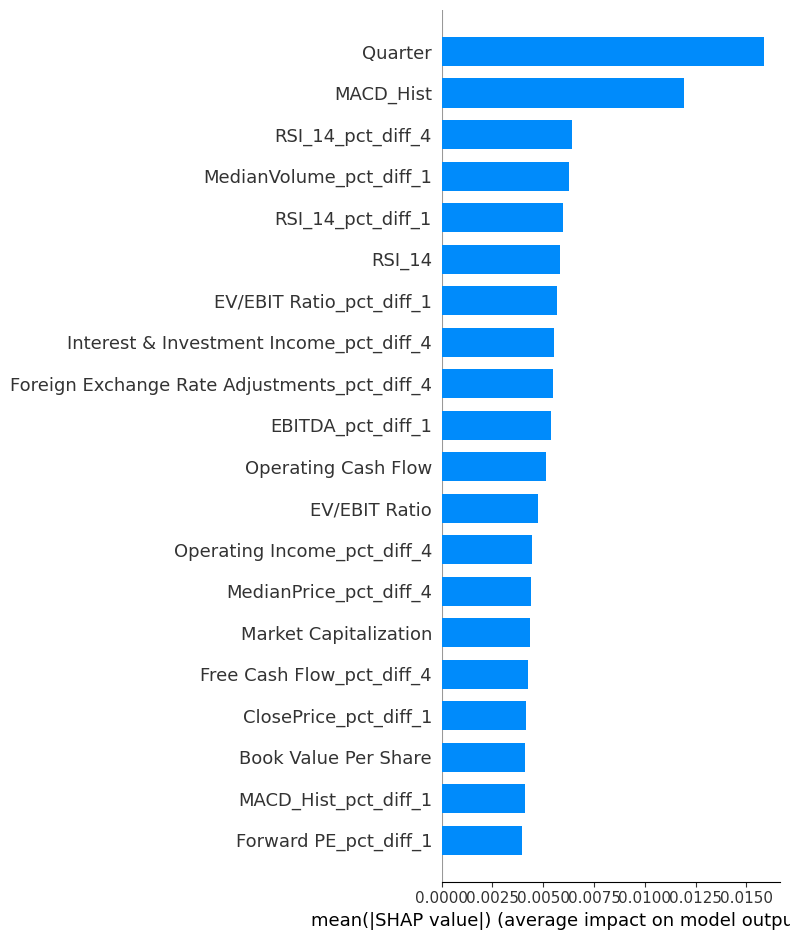

In [17]:
# Use the best model and the selected features
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train[selected])

# Global summary plot (bar)
shap.summary_plot(shap_values, X_train[selected], plot_type="bar")

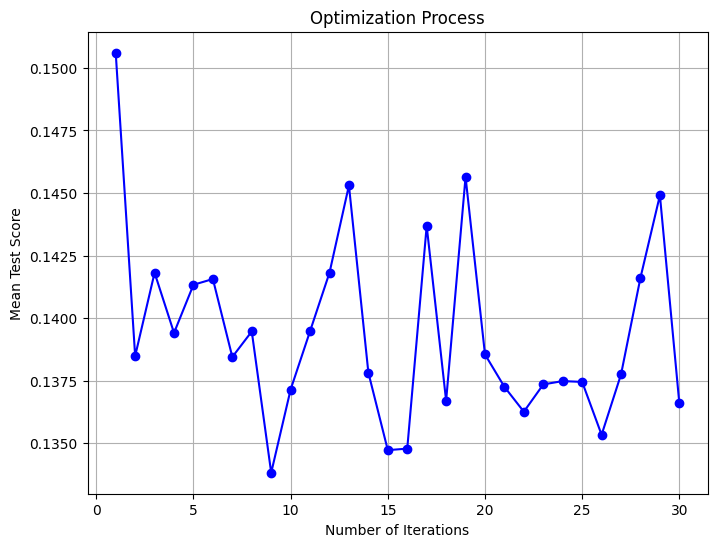

In [18]:
# Extract the results
results = pd.DataFrame(opt.cv_results_)
results['mean_test_score'] = -results['mean_test_score']

# Extract the mean test scores and number of iterations
iterations = np.arange(1, n_iter + 1)

# Plot the scores
plt.figure(figsize=(8, 6))
plt.plot(iterations, results['mean_test_score'],
         marker='o', linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Test Score')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

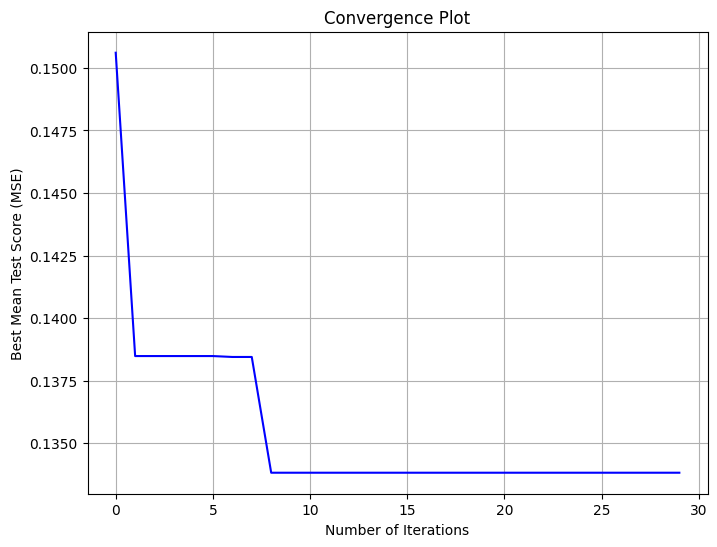

In [19]:
# Extract best scores at each iteration
best_scores = np.minimum.accumulate(results['mean_test_score'])

# Plot the convergence
plt.figure(figsize=(8, 6))
plt.plot(best_scores, linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Best Mean Test Score (MSE)')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()

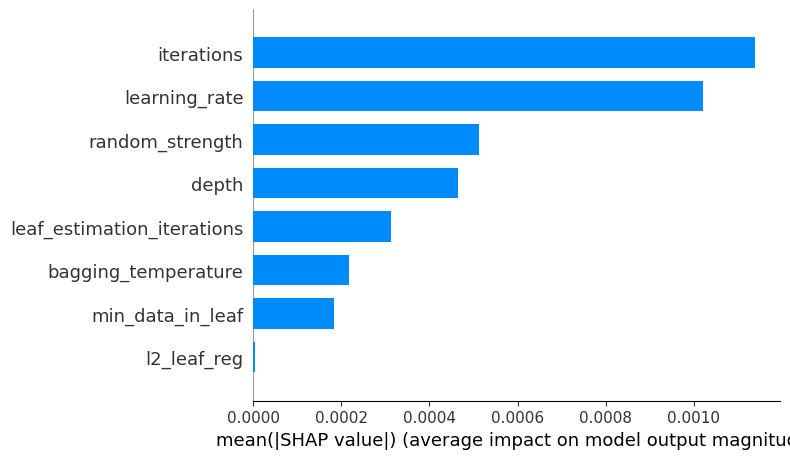

In [20]:

# Mean test scores are negative due to the scoring used
mean_test_scores = -results['mean_test_score']

# Create a DataFrame for analysis
hyperparams_df = pd.DataFrame(params)
hyperparams_df['mean_test_score'] = mean_test_scores

# If any hyperparameters are strings (e.g. loss_function), encode them
for col in hyperparams_df.drop('mean_test_score', axis=1).select_dtypes(include='object').columns:
    hyperparams_df[col] = hyperparams_df[col].astype('category').cat.codes

# Rebuild a fresh CatBoostRegressor with the best hyperparameters from search
best_params = opt.best_params_

# Fit a simple model to explain the hyperparameter importance
hyperparam_model = CatBoostRegressor(**best_params, verbose=0)

hyperparam_model.fit(
    hyperparams_df.drop('mean_test_score', axis=1),
    hyperparams_df['mean_test_score']
)

hyperparam_model.fit(hyperparams_df.drop(
    'mean_test_score', axis=1), hyperparams_df['mean_test_score'])


# Create a SHAP explainer
explainer = shap.Explainer(hyperparam_model)
shap_values = explainer(hyperparams_df.drop('mean_test_score', axis=1))

# Plot feature importance based on SHAP values
shap.summary_plot(shap_values, hyperparams_df.drop(
    'mean_test_score', axis=1), plot_type="bar")

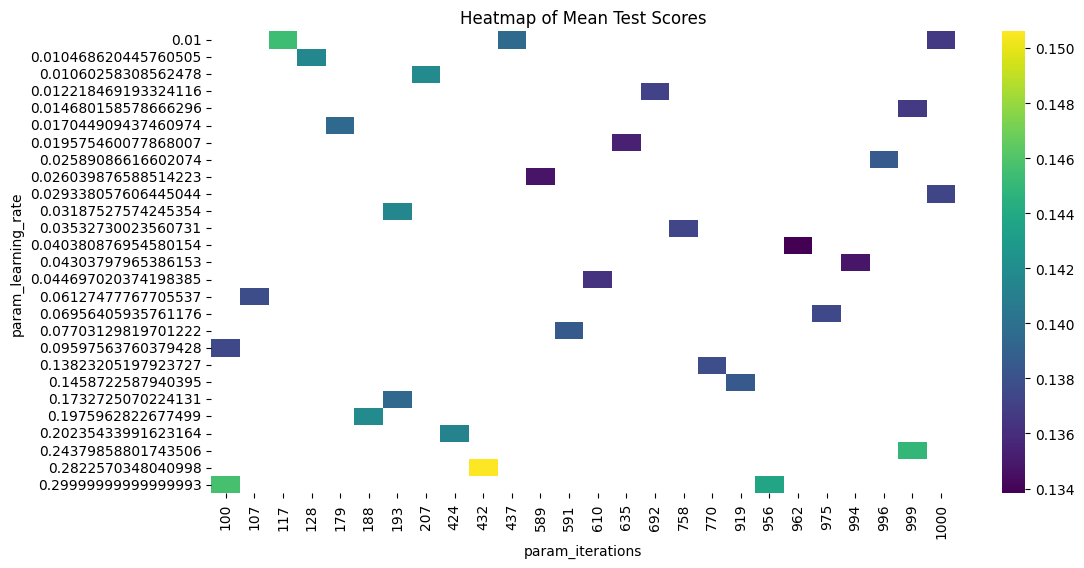

In [21]:
# Create a pivot table for the heatmap
pivot_table = pd.DataFrame(results).pivot_table(
    values='mean_test_score',
    index='param_learning_rate',
    columns='param_iterations',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=False, fmt=".1f", cmap="viridis")
plt.title('Heatmap of Mean Test Scores')
plt.show()

In [22]:
# Predict on the test set using the best model
preds = best_model.predict(X_test[selected])
errors = np.abs(test_df[target] - preds)

# Create a DataFrame to store actual, predicted, and errors
error_df = test_df[['Ticker', 'Date', target]].copy()
error_df['Predicted'] = preds
error_df['Absolute Error'] = errors

# Sort by error in descending order and display the top 30
top_30_errors = error_df.sort_values(
    by='Absolute Error', ascending=False).head(30)

print('Mean absolute error:', np.mean(errors))
print(top_30_errors)

Mean absolute error: 0.13474866063233096
     Ticker        Date  Future_Price_pct_diff_1  Predicted  Absolute Error
6914   TRMB  2025-01-03                -0.199235  -0.011494        0.187741
4346    LHX  2025-01-03                -0.004105   0.109196        0.113302
4298   LDOS  2025-01-03                -0.092477   0.010727        0.103204


In [23]:
best_model = joblib.load('sp500_best_catboost_model.pkl')

In [24]:
preds = best_model.predict(predict_df[selected])

In [25]:
predict_df = pd.DataFrame([predict_df['Ticker'].unique(), preds*100]).T.rename(
    columns={0: 'Ticker', 1: 'Predicted price change pct'})
predict_df.sort_values(by='Predicted price change pct',
                       ascending=False).head(30)

,Ticker,Predicted price change pct
366,PLTR,16.710521
449,ULTA,10.680816
281,LRCX,10.671169
337,NVDA,10.30892
427,TGT,10.219025
412,STX,9.891499
178,FDX,9.289243
91,CLX,8.743146
317,MSFT,8.495043
285,LW,8.478404
